By: Thomas Young

In this notebook, I describe ARIMA time series modeling and use the statmodels package to fit an seasonal ARIMA (SARIMA) model to some time series data.

Python functions are modified from the kaggle notebook at:
 
https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python#Econometric-approach

Data is the air quality dataset from the UC Irvine Machine Learning Repository

## What are ARIMA models?

ARIMA models are a popular way to model time series data. Time series data consists of repeated measurements of some type of data, ordered with respect to time. The goal is to use data from the past to forecast the value of of some target variable in the feature. ARIMA models can do this for time series data that satisfies the property of stationary. For stationary, several criteria must be met: 

1) There cannot be any trends.\
2) The variance of the data cannot be a function of time.\
3) The covariance between observations separated by a lag cannot depend on time.\

If these assumptions are met, an ARIMA model can be used to fit the data.

The predictors in an ARIMA model can be broken up into two parts. The 'AR' in 'ARIMA' stands for autoregressive. This means the the measurement at any time t, is a linear function of the previous measurements at time t-1, t-2,... t- k for some k.  The 'MA' in 'ARIMA' stands for moving average. This means that the measurement at a time t is a linear function of a set of error terms occuring at time t-1, t-2, ..... t-j for some j.  The 'I' in ARIMA models stands for integration. This means that in going from the auto-regressive, moving average model which predicts some x_t, to predicting the actual time series of interest y_t, one often needs to integrate/sum consectutive x_t terms up to the time of interest.  The reason for this is that the time series of interest y_t is often non-stationary. Taking consecutive differences, or the differences of those differences is needed to transform the time series y_t to a a stationary one x_t. The stationary series is then modeled as a sum of autoregressive and moving average terms.

A useful extension of ARIMA is the seasonal ARIMA model of SARIMA.  SARIMA models treat the time series as the product of a seasonal ARIMA component and a non-seasonal ARIMA component. This allows the model to capture patterns in the time series that repeat over a regular period

## The data set

I use an air quality dataset from the UC Irvine Machine learning repository. This consists of 9358 hourly averaged responses for 5 metal oxide chemical sensors. The measurements were taken from a polluted street in an Italian city. For this notebook, I only focus performing time series analysis for the carbon monoxide (CO) measurements. This is attribute 3 in the table

In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

from sklearn.metrics import mean_absolute_error

%matplotlib inline

## Exploratory Data Analysius

In [2]:
dat = pd.read_csv('./AirQualityUCI/AirQualityUCI.csv',sep=';')

In [3]:
print(dat.head(10))
dat.rename(columns = {'PT08.S1(CO)':'COsen'},inplace=True)

         Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00    2,6       1360.0     150.0     11,9         1046.0   
1  10/03/2004  19.00.00      2       1292.0     112.0      9,4          955.0   
2  10/03/2004  20.00.00    2,2       1402.0      88.0      9,0          939.0   
3  10/03/2004  21.00.00    2,2       1376.0      80.0      9,2          948.0   
4  10/03/2004  22.00.00    1,6       1272.0      51.0      6,5          836.0   
5  10/03/2004  23.00.00    1,2       1197.0      38.0      4,7          750.0   
6  11/03/2004  00.00.00    1,2       1185.0      31.0      3,6          690.0   
7  11/03/2004  01.00.00      1       1136.0      31.0      3,3          672.0   
8  11/03/2004  02.00.00    0,9       1094.0      24.0      2,3          609.0   
9  11/03/2004  03.00.00    0,6       1010.0      19.0      1,7          561.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.

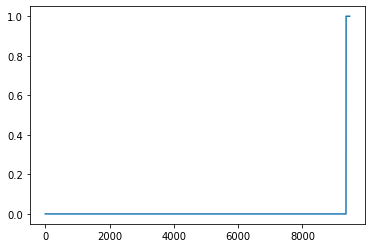

In [4]:
#Checking for missing values
plt.plot(dat.COsen.isna())

In [5]:
#Dropping the missing values
dat.dropna(subset = ['COsen'],inplace=True)

In [6]:
#I used functions found in the notebook at https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python#Econometric-approach

def tsplot(y, lags=None, figsize=(12, 12), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

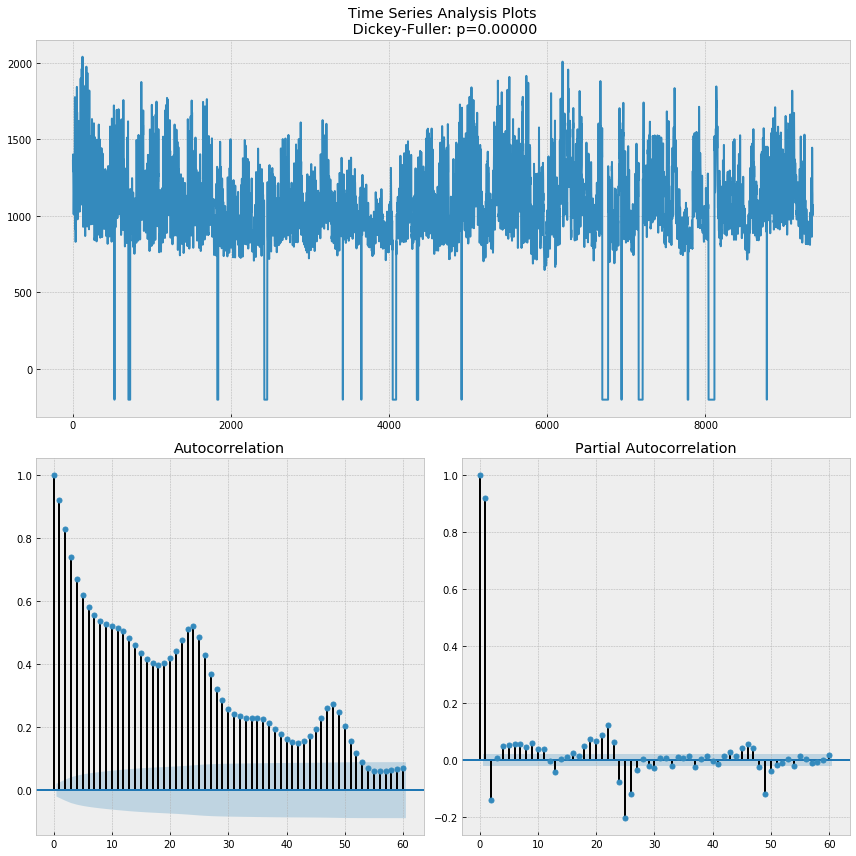

In [7]:
tsplot(dat.COsen,lags=60)

The Dickey-Fuller Test p-value is very small, so I reject the null hypothesis that a unit root is present. The time series is stationary.

The autocorrelation plot has local maximimum at multiples of 24 hours, so there is likely seasonality with respect to each day. To get rid of this, I took seasonal differences with a shift of 24 hours.

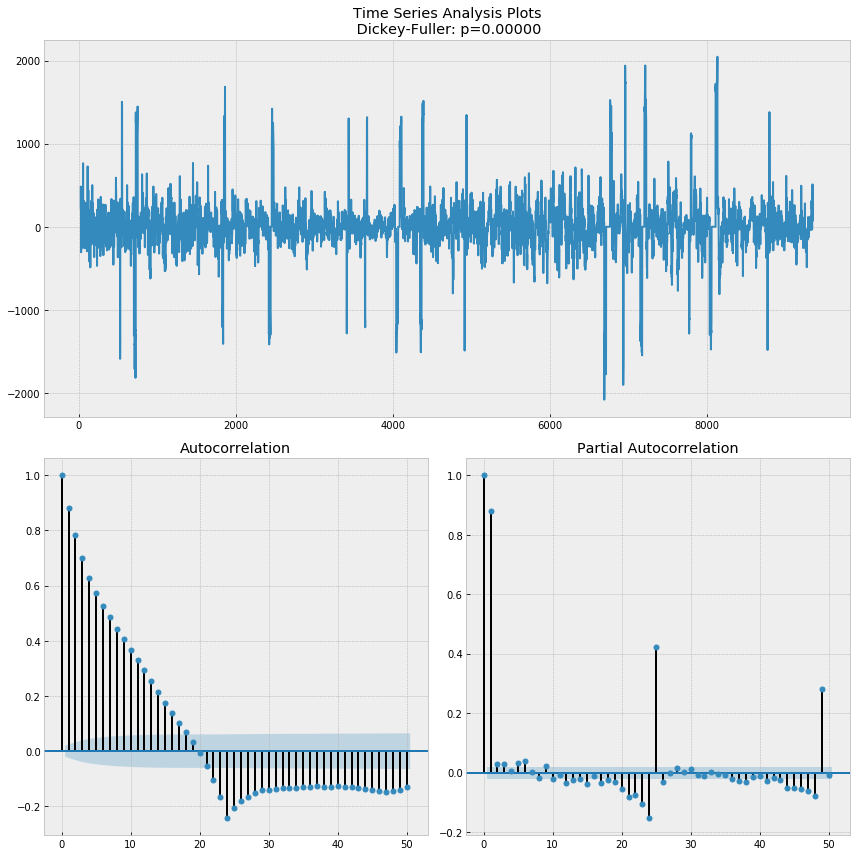

In [8]:
co_diff= dat.COsen - dat.COsen.shift(24)
co_diff = co_diff[24:]
tsplot(co_diff,lags=50)

Based on the autocorrelation plot, the seasonality appears to be removed. There are no longer any positive peaks in autocorrelation at multiples of 24.  The magnitude of the autocorrelations appears to drop much more quickly to 0. With the seasonally differenced data there is now a negative peak in autocorrelation at a lag of 24.

In terms of partial autocorrelation for small lags (<20), there is a peak at 1 followed by insignificant autocorrelations. For larger lags (>24), there are peaks at 24, 48, 72. 

The tapering down of the partial autocorrelation function at lag multiples of 24, and drop off of the autocorrelation function beyond a lag of 24 suggests the seasonal moving average component has order 1.  The lack of a sudden drop off at lag multiples of 24 suggests that the seasonal autoregressive component might have order 0.

The tapering decrease of the autocorrelation function at small lags (<20), and drop off in the PACF for lags greater than 1 and less than 24 suggests the non-seasonal autoregressive component has order 1, and the nonseasonal moving average component has order 0. Since the PACF lags are significant up to lag 3, I consider autoregressive orders up to 3.


In addition to fitting the above SARIMA model, I perform another differencing operation with a shift of 1 and fit an SARIMA model to this transformed data. The reason for exploring this, is that the seasonally differenced time series above has a lot of significant lags. Removing these lags might improve the performance of the model.

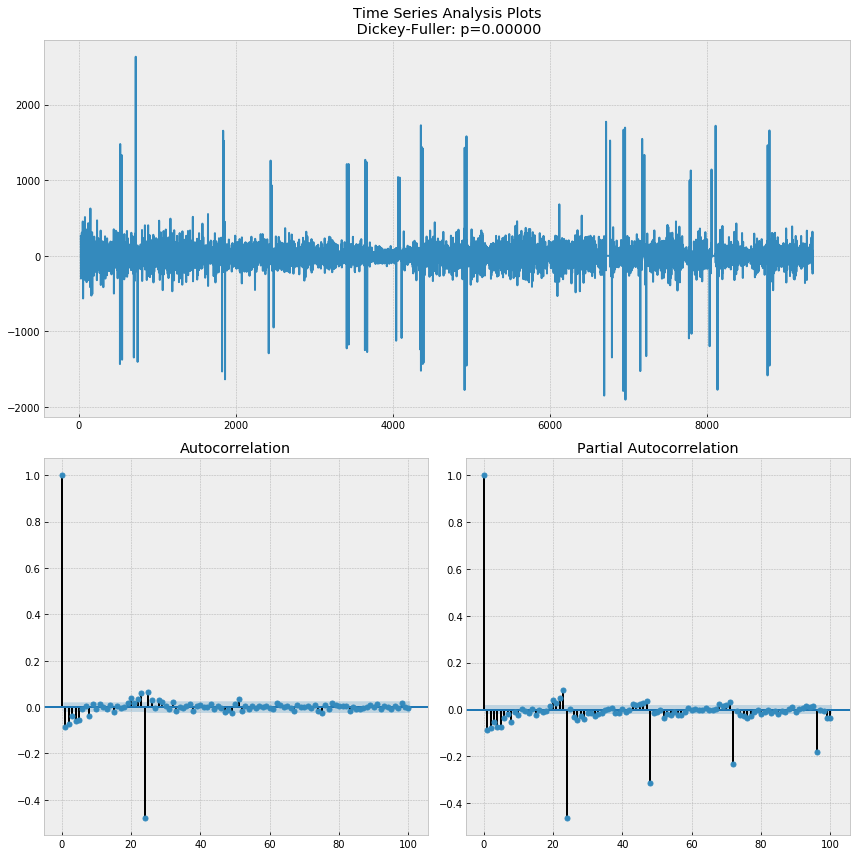

In [9]:
co_diff1 = co_diff - co_diff.shift(1)
co_diff1 = co_diff1[1:]
tsplot(co_diff1,lags=100)

Now, there is only one signficant negative peak of autocorrelation at a lag of 24.  For partial autocorrelation, there are significant negative peaks at lags of 24,48,...

Looking at lags corresponding to the seasonal period (24) hours, the partial autocorrelation at multiples of 24 tapers to 0. The autocorrelation is 0 for lags greater than 24. This is consistent with the seasonal component moving average with order 1.  The autoregressive seasonal component has order 0 since there is no tapering of the autocorrelation function at multiples of 24.

Looking at small lags, there are significant but small autocorrelations up to lag 5. Partial autocorrelations taper to 0 more gradually. This could be consistend with a non-seasonal moving average order of 5.

## Fitting the SARIMA Models

In [10]:
# setting initial values and some bounds for them
ps = range(2, 4)
d=0 
qs = range(2, 4)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [11]:
#Again coppied from the notebook at: https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python#Econometric-approach

def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(dat.COsen, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table


In [12]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

/Users/thomasyoung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/thomasyoung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/thomasyoung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/thomasyoung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/thomasyoung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: Converge


CPU times: user 2h 7min 19s, sys: 1min 47s, total: 2h 9min 6s
Wall time: 1h 16min 28s


In [13]:
result_table

,parameters,aic
0,"(3, 3, 1, 1)",114907.519095
1,"(2, 3, 1, 1)",114909.011698
2,"(2, 2, 1, 1)",114909.126091
3,"(3, 3, 0, 1)",114923.304487
4,"(2, 3, 0, 1)",114924.677834
5,"(2, 2, 0, 1)",114925.022112
6,"(3, 2, 0, 1)",114951.829705
7,"(3, 2, 1, 1)",115292.672634
8,"(3, 3, 1, 0)",117929.367341
9,"(3, 2, 1, 0)",118002.339237


In [14]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(dat.COsen, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                COsen   No. Observations:                 9357
Model:             SARIMAX(3, 0, 3)x(1, 1, [1], 24)   Log Likelihood              -57444.760
Date:                              Sat, 19 Sep 2020   AIC                         114907.519
Time:                                      17:00:03   BIC                         114971.791
Sample:                                           0   HQIC                        114929.350
                                             - 9357                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.4094      0.226     10.674      0.000       1.967       2.852
ar.L2         -1.95

The choice of SARIMA parameters with the lowest AIC, has non-seasonal autoregressive and moving average orders of 2, a seasonal autoregressive order of 1, and a seasonal moving average order of 0. The seasonal AR and MA orders were expected based on the PACF and ACF plots. The better performance of higher non-seasonal AR and MA orders was also not terribly surprising considering the ACF and PACF were significant up to these lags.

The Ljung Box Statistic (a weighted sum of autocorrelations between residuals) is used to assess whether the autocorrelations between error terms are 0.  Since this is an assumption of ARIMA models, a small Ljung Box Statistic is more desirable. In the case of the best choice of SARIMA parameters tha I considered, the p-value for the Ljung Box Statistic Test was very small. Therefore a Ljung Box statistic as large as what I observed (88.16) would be highly unlikely considering a time series model in which the noise terms are IID. The model has problems.

## Diagnostic Plots

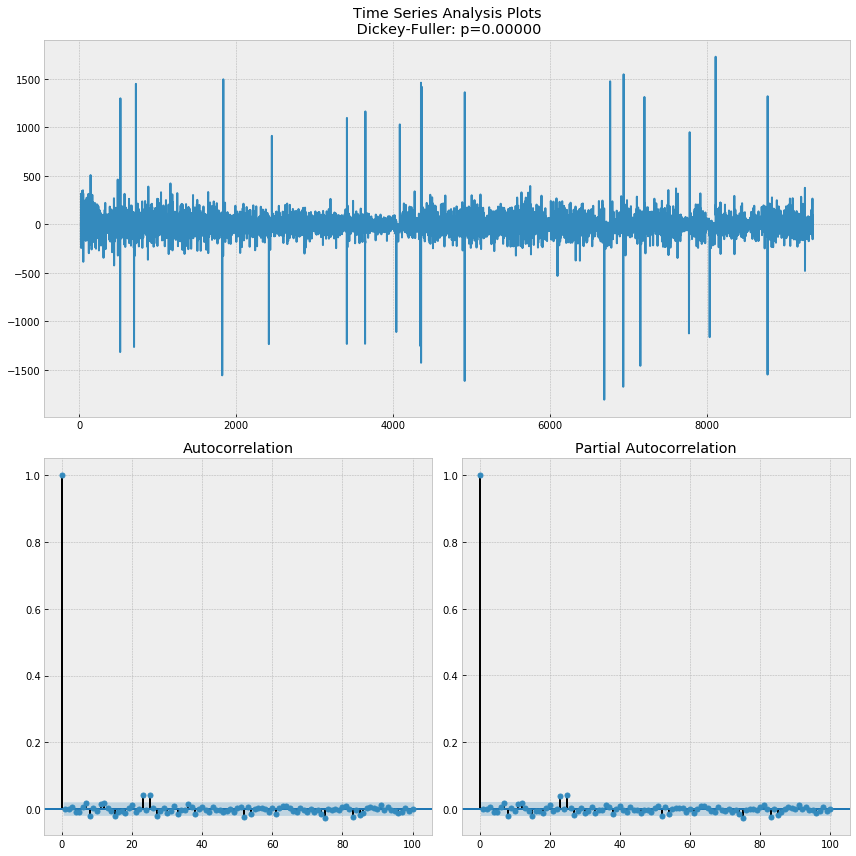

In [15]:
#Plotting the residuals of the best fitted model
tsplot(best_model.resid[24:], lags=100)

Looking at the ACF and PACF of the residuals of my best fitting model, a few problems come up.  Although most autocorrelation and partial autocorrelation values are not significant, at lags of 23,24,and 25, they are significant.  Shifting the lag by multiples of 24 also yields significant autocorrelation and partial autocorrelation values. My interpretation of this is that is that the model is not able to capture the autocorrelation in the time series at these lags. So when time t is underpredicted by my fitted model, time t+23,t+24, and t+25 are also being underpredicted by my fitted model.

One solution that I would look into is using a higher order for the non-seasonal AR and MA terms. The PACF and ACF of the seasonally difference time series were significant up to lag 3 but I only checked up to order 2.

I next wanted to see how the predictions of the SARIMA Model compare to the true values of the time series. I computed the mean absolute error between the fitted and predicted values of the time series. I also plot the model predictions from time 0 up to 50 hours past the end of the time series.

In [16]:
#Again coppied from the notebook at: https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python#Econometric-approach

def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.to_frame()
    data.columns = ['actual']
    print(data.head(5))
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating. s is the seasonal difference, d is the nonseasonal difference
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Error: {0:.2f}".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

   actual
0  1360.0
1  1292.0
2  1402.0
3  1376.0
4  1272.0


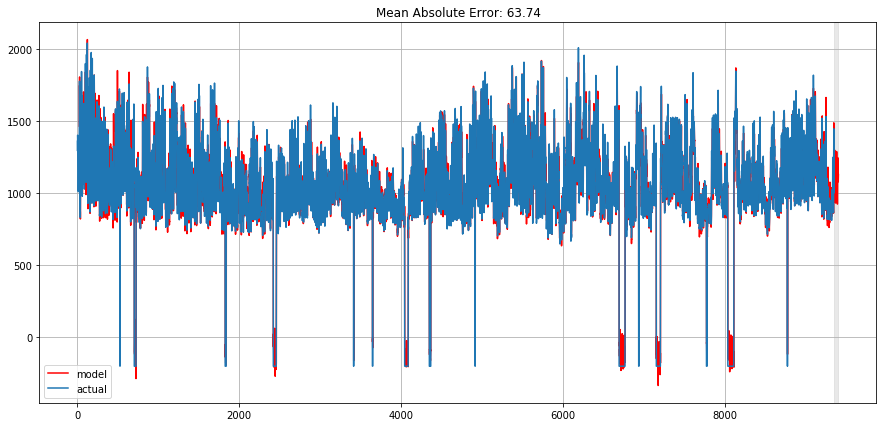

In [17]:
plotSARIMA(dat.COsen, best_model, 50)

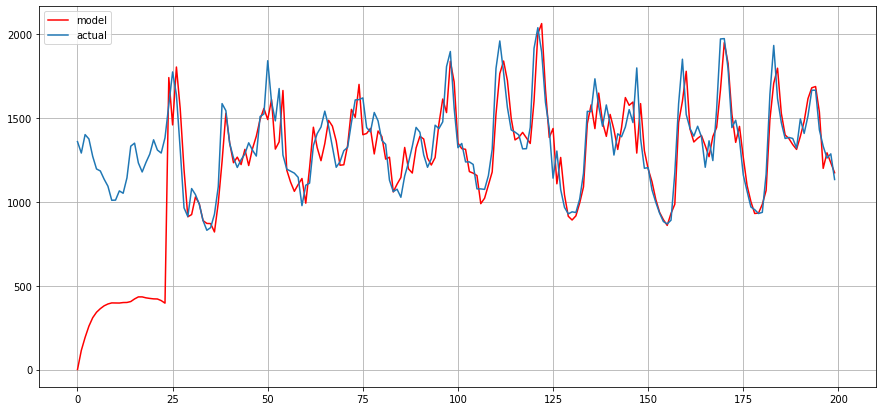

In [18]:
#Plotting on a smaller time interval from hour 100 to hour 200.
# forecasting on n_steps forward 
data = dat.COsen.to_frame()
data.columns = ['actual']
data['arima_model'] = best_model.fittedvalues

    
plt.figure(figsize=(15, 7))
plt.plot(data.arima_model[:200], color='r', label="model")
plt.axvspan(200, 200, alpha=0.5, color='lightgrey')
plt.plot(data.actual[:200], label="actual")
plt.legend()
plt.grid(True);


To further assess the validaty of the SARIMA model assumptions, I consider a qqplot of the residuals

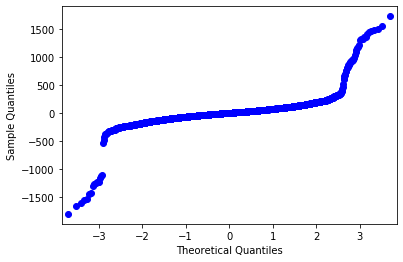

In [19]:
res = best_model.resid # residuals
fig = sm.qqplot(res)
plt.show()

If the residuals were normally distributed, the qqplot would have been a straight line. Instead, there are long tails in the positive and negative direction for the distribution of the residuals. The middle 95% of the residual distribution does look approximately normal though.  The poor fit to a normal distribution for the residuals, means that my SARIMA model is a poor fit to the data.  


## Conclusion


This notebook explored the fitting of SARIMA models to a air pollution data set, as well as diagnostics for model fit. Based on the poor performance of the fitted model, I would try higher values for the order of the nonseasonal autoregressive and moving average components